## 2. Redes Convolucionales sobre imágenes
---
Las redes neuronales hoy en día han sido extendidas a numerosas aplicaciones gracias a la arquitectura definida para cada tipo de problema. Las redes neuronales que aplican la operación de convolución [[3]](#refs) o convoluciones en sus capas son concidas como *CNN* o *ConvNets*, lo cual se especializa en trabajar en datos con forma matricial (ya sea bi-dimensional o tri-dimensional), lo cual se adecúa perfectamente a imágenes (matrices), ya que gracias a su conectividad local se especializan en reconocer patrones sobre los datos de manera espacial, como refleja la siguiente imagen:

<img src="https://cdn-images-1.medium.com/max/1600/1*N4h1SgwbWNmtrRhszM9EJg.png" title="Title text" width="90%" />


En esta actividad trabajará con un extracto bastante pequeño del dataset conocido como **101-Food**[[4]](#refs), el cual consta de mil imágenes pertenecientes a 3 clases (*Hambuger, Hot Dog* y *Pizza*) separados en conjunto de entrenamiento y validación.  
El extracto pequeño del dataset con el que se trabajará deberá ser descargado del siguiente __[link](https://www.dropbox.com/s/56xqazmhbh0doi7/food_data.zip?dl=0)__ a través de Dropbox.

> a) Construya funciones para leer los datos y cargarlos al momento de entrenar (durante cada *epoch*), para ésto utilice *Image Data Generator* de keras.

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import *
import time
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt

C:\Users\kzep\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255) #no transformation
train_generator = train_datagen.flow_from_directory(
        'food_data/train',
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=32)
validation_generator = test_datagen.flow_from_directory(
        'food_data/val',
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=32)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


> b) Utilice la red tradicional (*Feed Forward*) entregada en el código para ser entrenada sobre los datos vectorizados, esto es que cada imagen queda representada como un vector gigante, y las 3 clases a las que se enfrenta. Evalúe el modelo con la métrica *accuracy* sobre el conjunto de validación.

In [9]:
%%time
ltime=[]
step = []
error = []
model = Sequential()
model.add(Flatten(input_shape=train_generator.image_shape)) #full dense
model.add(BatchNormalization()) #to normalize the input..
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu')) #128
model.add(Dropout(0.25))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Let's train the model using RMSprop
model.summary()
model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator.classes)//train_generator.batch_size, #samples//batch_size
        epochs=25,
        validation_data=validation_generator,
        validation_steps=len(validation_generator.classes)//validation_generator.batch_size)
for i in range(50):
    error.append(model.evaluate_generator(generator=validation_generator,steps = i+1)[1])#probar algo distinto de 2
    print("Accuracy validation: ",error[i])
    end = time.time()
    step.append(i)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 67500)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 67500)             270000    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               17280256  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total para

Con fines personales:

steps 1 - Acuraccy 0.41666666

Steps 2 - Acuraccy 0.484375

Steps 3. Accuracy 0.4375

Steps 4 - Accuracy 0.484375

Stepts 5 - Accuracy 0.49375

Steps 6- Accuracy 0.40760869



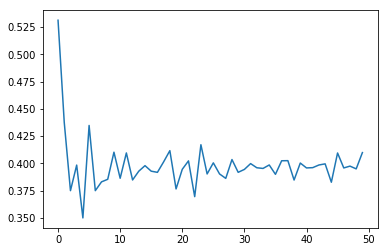

In [4]:
plt.plot(step,error)

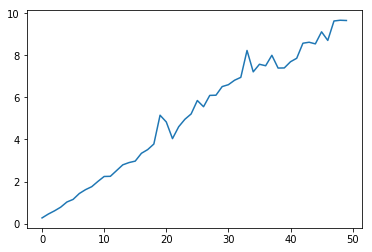

In [5]:
plt.plot(step,ltime)

> c) Utilice la red convolucional (**CNN**) entregada en el código para ser entrenada sobre los datos brutos, matrices RGB de píxeles, y las 3 clases a las que se enfrenta. Evalúe el modelo con la métrica *accuracy* sobre el conjunto de validación. Compare.

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=train_generator.image_shape,activation='relu'))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(len(train_generator.class_indices),activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Let's train the model using RMSprop
model.summary()
model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator.classes)//train_generator.batch_size, #samples//batch_size
        epochs=25,
        validation_data=validation_generator,
        validation_steps=len(validation_generator.classes)//validation_generator.batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 148, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
__________

> d) Genere un conjunto datos con incorrecta etiquetación de manera manual y vea si el modelo convolucional se sigue comportando de la misma manera. Para esto tome 100 imágenes aleatorias de entrenamiento de la carpeta *hot dog* y 100 imágenes aleatorias de entrenamiento de la carpeta *hamburger* e intercambielas, sin manipular las imágenes de la carpeta *pizza* y con el conjunto de validación intacto. Genere las matrices de confusión en el conjunto de validación para visualizar cómo afectó al modelo la corrupción realizada a los datos.

In [7]:
Y_pred = model.predict_generator(validation_generator,len(validation_generator.classes)//validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
confusion_matrix = confusion_matrix(validation_generator.classes, y_pred)

In [8]:
print(confusion_matrix)

[[ 39  62  99]
 [ 45  55 100]
 [ 28  64 108]]
